# **Flight Fare Prediction**



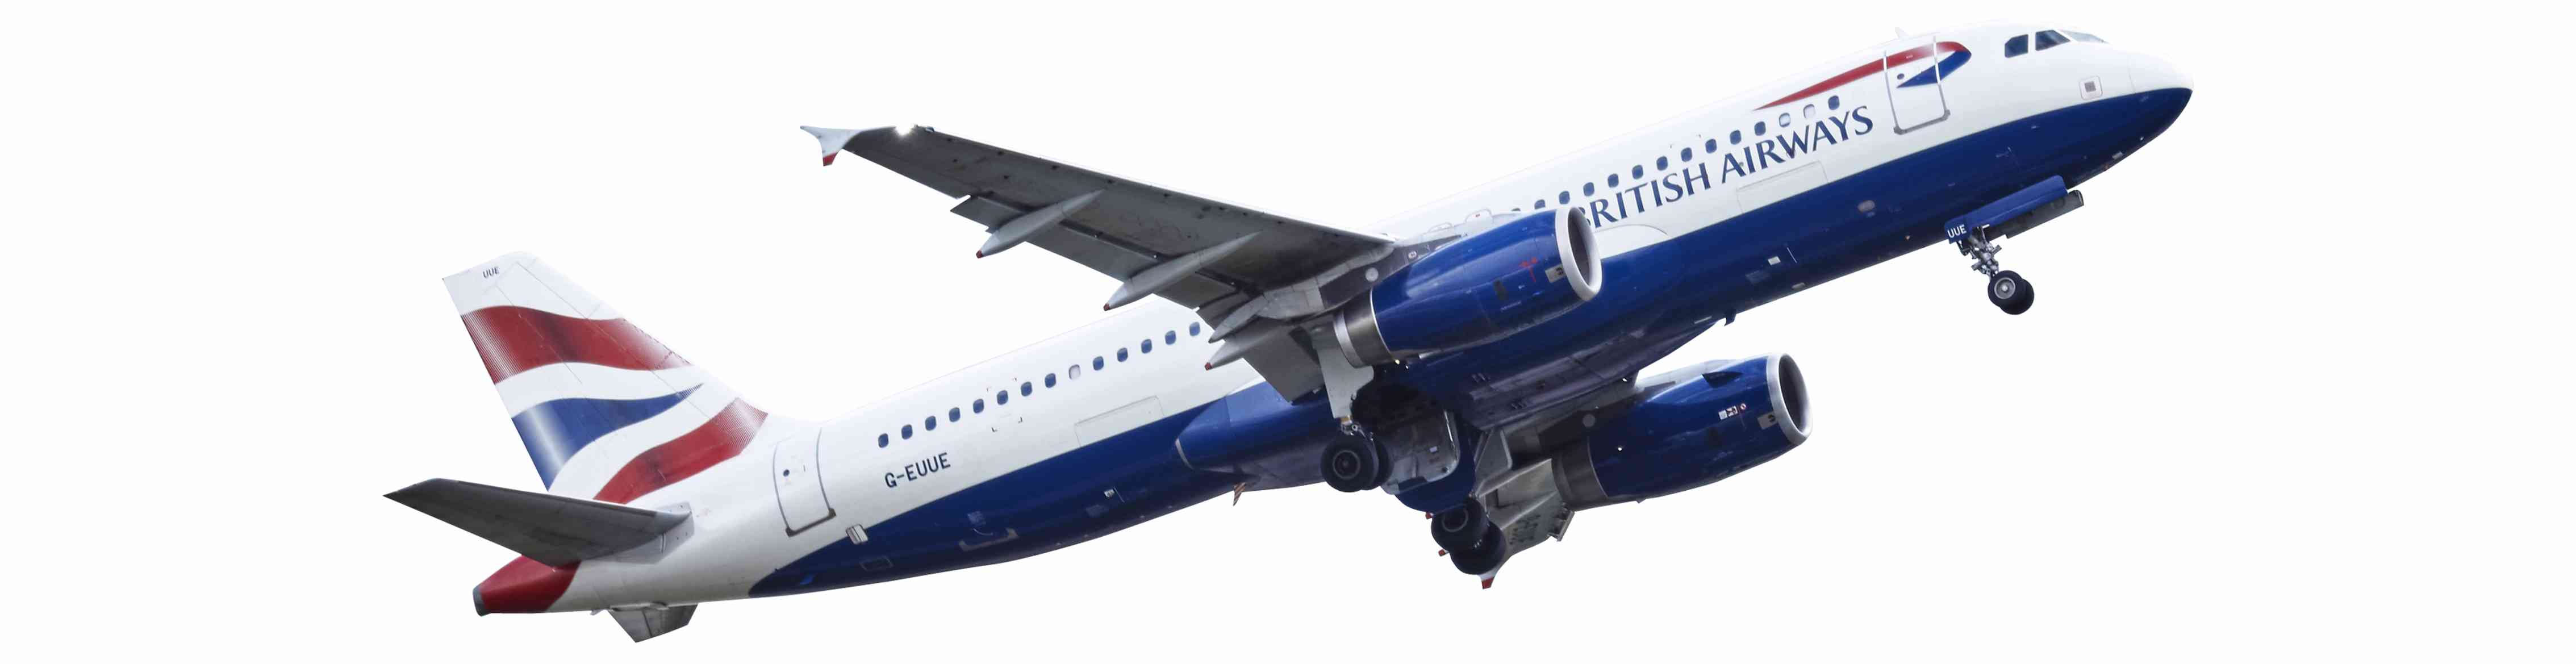

**Description**

Guessing the flight prices can be very hard sometimes, today we might see a price but when we check out the same flight the price might be different. We might have often heard travelers saying that flight ticket prices are so unpredictable. Here we will be provided with different prices of flight tickets for various airlines in the year of 2019 and between various cities.

Number of Flight Records: 10683

Number of Airline: 12

Time Span: Jan 2019 to Dec 2019

Number of Attributes/Columns in data: 11

####Attribute Information: 


1. Airline - The name of the airline.
2. Date_of_Journey - The date of the journey.
3. Source - The source from which the service begins.
4. Destination - The destination where the service ends.
5. Route - The route taken by the flight to reach the destination.
6. Dep_Time - The time when the journey starts from the source.
7. Arrival_Time - Time of arrival at the destination.
8. Duration - Total duration of the flight.
9. Total_Stops - Total stops between the source and destination.
10. Additional_Info - Additional information about the flight
11. Price - The price of the ticket

####Objective:

We will use these flight records to determine flight prices based on the different parameters.



# Importing Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from prettytable import PrettyTable

# Reading Data

In [8]:
data = pd.read_excel('Data.xlsx')
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Exploratory Data Analysis

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [10]:
# Check for any missing values
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [11]:
# As we have few missing value we can directly drop these
data.dropna(inplace=True)
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [12]:
# Check for any duplicate values
data[data.duplicated()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303
...,...,...,...,...,...,...,...,...,...,...,...
10594,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,12:35 28 Jun,13h 30m,2 stops,No info,12819
10616,Jet Airways,1/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 02 Jun,26h 55m,2 stops,No info,13014
10634,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 07 Jun,26h 55m,2 stops,In-flight meal not included,11733
10672,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,19:00 28 Jun,19h 55m,2 stops,In-flight meal not included,11150


In [13]:
# Dropping duplicate values
data.drop_duplicates(keep='first',inplace=True)

# Feature Engineering

In [14]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [15]:
# Convert Object to DateTime dtype
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'])
data['Dep_Time'] = pd.to_datetime(data['Dep_Time'])
data['Arrival_Time'] = pd.to_datetime(data['Arrival_Time'])

In [16]:
# Extract date and month from Date_of_Journey and drop the column as it is of no use
data['Journey_day'] = data['Date_of_Journey'].dt.day
data['Journey_month'] = data['Date_of_Journey'].dt.month
data.drop('Date_of_Journey', axis=1, inplace=True)

In [17]:
# Extract hour and minute from Dep_Time and drop the column as it is of no use
data['Dep_hour'] = data['Dep_Time'].dt.hour
data['Dep_minute'] = data['Dep_Time'].dt.minute
data.drop('Dep_Time', axis=1, inplace=True)

# Similarly for Arrival_Time
data['Arrival_hour'] = data['Arrival_Time'].dt.hour
data['Arrival_minute'] = data['Arrival_Time'].dt.minute
data.drop('Arrival_Time', axis=1, inplace=True)

In [18]:
# Function to extract hour
def extract_hour(x):
    if len(x.split(' ')) == 2:
        return x.split(' ')[0][0:-1]
    elif 'h' in x:
        return x[0:-1]
    else:
        return '0'

# Function to extract minute
def extract_min(x):
    if len(x.split(' ')) == 2:
        return x.split(' ')[1][0:-1]
    elif 'm' in x:
        return x[0:-1]
    else:
        return '0'

In [19]:
# Extract hour and minute from Dep_Time and drop the column as it is of no use
data['Duration_hour'] = data['Duration'].apply(extract_hour)
data['Duration_minute'] = data['Duration'].apply(extract_min)
data.drop('Duration', axis=1, inplace=True)

In [20]:
data.dtypes

Airline            object
Source             object
Destination        object
Route              object
Total_Stops        object
Additional_Info    object
Price               int64
Journey_day         int64
Journey_month       int64
Dep_hour            int64
Dep_minute          int64
Arrival_hour        int64
Arrival_minute      int64
Duration_hour      object
Duration_minute    object
dtype: object

In [21]:
# Convert object to int dtype
data['Duration_hour'] = data['Duration_hour'].astype(int)
data['Duration_minute'] = data['Duration_minute'].astype(int)

In [22]:
# Categorical Features
categorical_col=[col for col in data.columns if data[col].dtype=='O']
categorical_col

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [23]:
# Numerical Features
numeric_col=[col for col in data.columns if data[col].dtype!='O']
numeric_col

['Price',
 'Journey_day',
 'Journey_month',
 'Dep_hour',
 'Dep_minute',
 'Arrival_hour',
 'Arrival_minute',
 'Duration_hour',
 'Duration_minute']

# Handling Categorical Data


We are using 2 main Encoding Techniques to convert Categorical data into some numerical format
    

> Nominal data --> data does not have any order --> OneHotEncoder is used in this case


> Ordinal data --> data have some order --> LabelEncoder is used in this case

In [24]:
categorical = data[categorical_col]
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info


# Airline vs Price Analysis

In [25]:
categorical['Airline'].value_counts()

Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

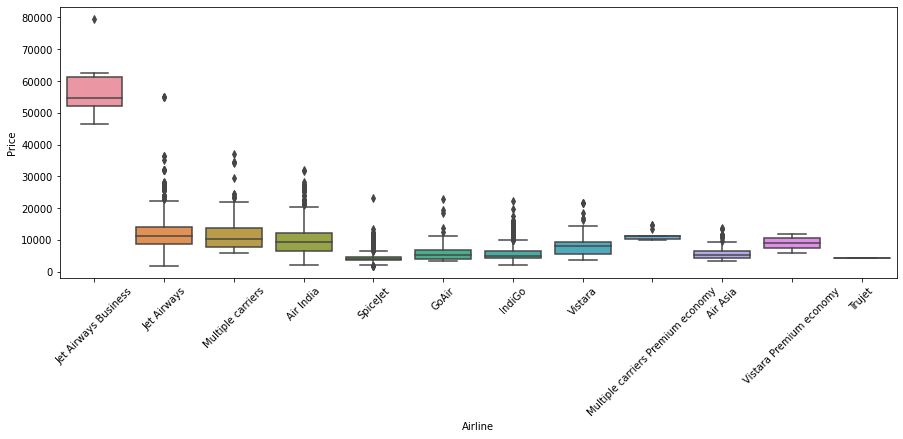

In [26]:
plt.figure(figsize=(15,5))
sns.boxplot(y='Price',x='Airline',data=data.sort_values('Price',ascending=False))
plt.xticks(rotation=45)
plt.show()

Observation:

1. From graph we can see that Jet Airways Business have the highest Price. 
2. Apart from the first Airline almost all are having similar median

In [27]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding
Airline = pd.get_dummies(categorical['Airline'], drop_first=True)
Airline.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


# Total_Stops vs Price Analysis

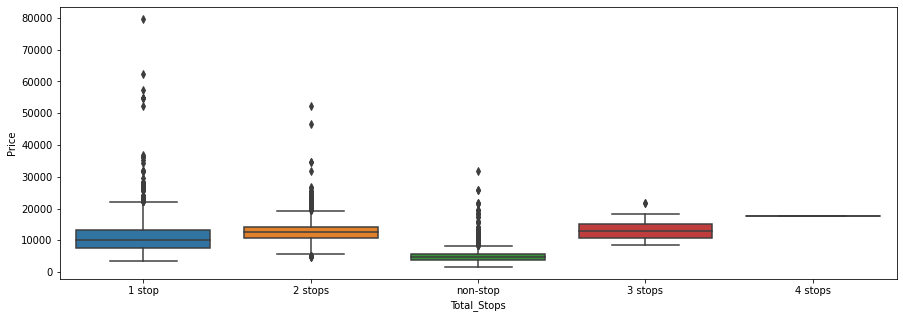

In [29]:
plt.figure(figsize=(15,5))
sns.boxplot(y='Price',x='Total_Stops',data=data.sort_values('Price',ascending=False))
plt.show()

Observation:

1. Flights with 1 stop have a higher fare than others.
2. Flights with 4 stops doesn't fluctuate very much and has the highest median.

# Source vs Price Analysis

In [30]:
categorical['Source'].value_counts()

Delhi       4345
Kolkata     2860
Banglore    2179
Mumbai       697
Chennai      381
Name: Source, dtype: int64

<Figure size 1080x360 with 0 Axes>

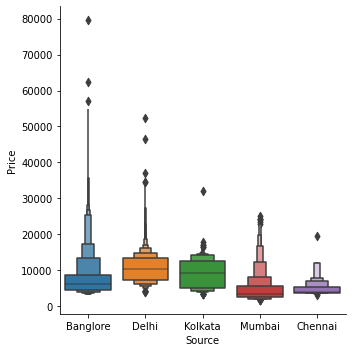

In [31]:
plt.figure(figsize=(15,5))
sns.catplot(y='Price',x='Source',data=data.sort_values('Price',ascending=False),kind='boxen')
plt.show()

Observations:

1. Bangalore has the highest fluctuation.
2. Delhi has the highest median compared to all other metropolitan cities of India.

In [32]:
# As Source is Nominal Categorical data we will perform OneHotEncoding
Source=pd.get_dummies(categorical['Source'], drop_first=True)
Source.head()

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


# Destination vs Price Analysis

In [33]:
categorical['Destination'].value_counts()

Cochin       4345
Banglore     2860
Delhi        1265
New Delhi     914
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

<Figure size 1080x360 with 0 Axes>

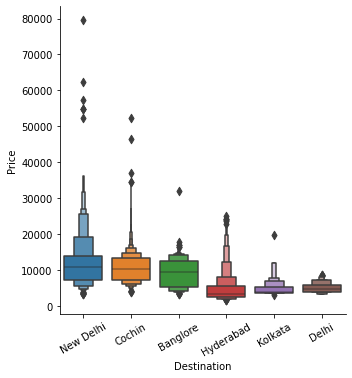

In [34]:
plt.figure(figsize=(15,5))
sns.catplot(y='Price',x='Destination',data=data.sort_values('Price',ascending=False),kind='boxen')
plt.xticks(rotation=30)
plt.show()

Observations:

1. New Delhi has the highest fluctuations.
2. New Delhi has the highest median compared to all other metropolitan cities of India.

In [35]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding
Destination=pd.get_dummies(categorical['Destination'], drop_first=True)
Destination.head()

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [36]:
categorical['Route'].unique()

array(['BLR → DEL', 'CCU → IXR → BBI → BLR', 'DEL → LKO → BOM → COK',
       'CCU → NAG → BLR', 'BLR → NAG → DEL', 'CCU → BLR',
       'BLR → BOM → DEL', 'DEL → BOM → COK', 'DEL → BLR → COK',
       'MAA → CCU', 'CCU → BOM → BLR', 'DEL → AMD → BOM → COK',
       'DEL → PNQ → COK', 'DEL → CCU → BOM → COK', 'BLR → COK → DEL',
       'DEL → IDR → BOM → COK', 'DEL → LKO → COK',
       'CCU → GAU → DEL → BLR', 'DEL → NAG → BOM → COK',
       'CCU → MAA → BLR', 'DEL → HYD → COK', 'CCU → HYD → BLR',
       'DEL → COK', 'CCU → DEL → BLR', 'BLR → BOM → AMD → DEL',
       'BOM → DEL → HYD', 'DEL → MAA → COK', 'BOM → HYD',
       'DEL → BHO → BOM → COK', 'DEL → JAI → BOM → COK',
       'DEL → ATQ → BOM → COK', 'DEL → JDH → BOM → COK',
       'CCU → BBI → BOM → BLR', 'BLR → MAA → DEL',
       'DEL → GOI → BOM → COK', 'DEL → BDQ → BOM → COK',
       'CCU → JAI → BOM → BLR', 'CCU → BBI → BLR', 'BLR → HYD → DEL',
       'DEL → TRV → COK', 'CCU → IXR → DEL → BLR',
       'DEL → IXU → BOM → COK', 'CCU 

In [37]:
# Since we have a maximum of 5 cities in between a journey split the route columns into 5 columns.
categorical['Route_1']=categorical['Route'].str.split('→').str[0]
categorical['Route_2']=categorical['Route'].str.split('→').str[1]
categorical['Route_3']=categorical['Route'].str.split('→').str[2]
categorical['Route_4']=categorical['Route'].str.split('→').str[3]
categorical['Route_5']=categorical['Route'].str.split('→').str[4]

In [38]:
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,BLR,NAG,DEL,NaN,NaN


In [39]:
categorical['Route_1'].fillna('None',inplace=True)
categorical['Route_2'].fillna('None',inplace=True)
categorical['Route_3'].fillna('None',inplace=True)
categorical['Route_4'].fillna('None',inplace=True)
categorical['Route_5'].fillna('None',inplace=True)

In [40]:
# Extract how many categories in each cat_feature
for feature in categorical.columns:
    print('{} has total {} categories \n'.format(feature,len(categorical[feature].value_counts())))

Airline has total 12 categories 

Source has total 5 categories 

Destination has total 6 categories 

Route has total 128 categories 

Total_Stops has total 5 categories 

Additional_Info has total 10 categories 

Route_1 has total 5 categories 

Route_2 has total 45 categories 

Route_3 has total 30 categories 

Route_4 has total 14 categories 

Route_5 has total 6 categories 



In [41]:
# As we have lot of features in Route , one hot encoding will not be a better option so lets appply Label Encoding
encoder = LabelEncoder()

In [42]:
for i in ['Route_1', 'Route_2', 'Route_3', 'Route_4','Route_5']:
    categorical[i]=encoder.fit_transform(categorical[i])

In [43]:
# Additional_Info contains almost 80% no_info,so we can drop this column
# we can drop Route as well as we have pre-process that column
categorical.drop('Route', axis=1, inplace=True)
categorical.drop('Additional_Info', axis=1, inplace=True)

In [44]:
categorical['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [45]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding key
dict={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}

categorical['Total_Stops']=categorical['Total_Stops'].map(dict)

In [46]:
categorical.head()

,Airline,Source,Destination,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,0,0,13,29,13,5
1,Air India,Kolkata,Banglore,2,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1,0,34,8,13,5


In [47]:
# Concatenate dataframe --> categorical + Airline + Source + Destination
data = pd.concat([categorical,Airline,Source,Destination,data[numeric_col]],axis=1)
# Drop Airline, Source and Destination columns
data.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)
data.head()

,Total_Stops,Route_1,Route_2,Route_3,Route_4,Route_5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hour,Duration_minute
0,0,0,13,29,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3897,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7662,5,1,5,50,13,15,7,25
2,2,3,32,4,5,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,13882,6,9,9,25,4,25,19,0
3,1,2,34,3,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6218,5,12,18,5,23,30,5,25
4,1,0,34,8,13,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13302,3,1,16,50,21,35,4,45


# Outlier Detection

In [48]:
def plot(df,col):
    fig,(ax1,ax2)=plt.subplots(2,1)
    sns.distplot(df[col],ax=ax1)
    sns.boxplot(df[col],ax=ax2)

<Figure size 2160x1440 with 0 Axes>

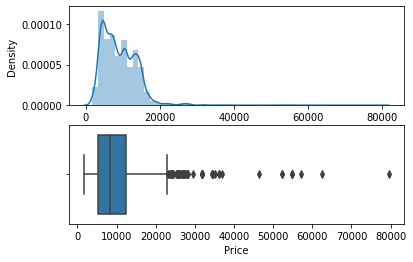

In [49]:
plt.figure(figsize=(30,20))
plot(data,'Price')

We set a threshold of 40000 (say we got this value after consulting a domain expert) above which we can consider the data point to be an outlier.

In [50]:
# Replace the outliers with median
data['Price'] = np.where(data['Price']>=40000, data['Price'].median(), data['Price'])

<Figure size 2160x1440 with 0 Axes>

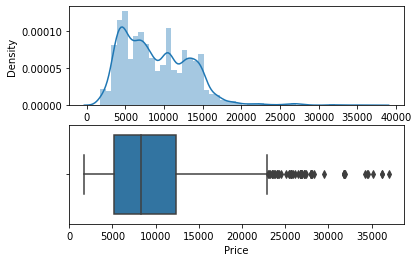

In [51]:
plt.figure(figsize=(30,20))
plot(data,'Price')

In [52]:
# Separate dependent and independent variables
X = data.drop('Price', axis=1)
Y = data['Price']

# Feature Selection

> Finding out the best feature which will contribute and have good relation with target variable.
    
### Why to apply Feature Selection?

> To select important features to get rid of curse of dimensionality ie..to get rid of duplicate features

### I wanted to find mutual information scores or matrix to get to know about the relationship between all features.

#### Feature Selection using Information Gain,

In [53]:
mutual_info_classif(X,Y)

array([2.14075644e+00, 2.03630591e+00, 2.75372111e+00, 2.27247572e+00,
       1.44426999e+00, 7.35657715e-01, 7.41066368e-01, 9.95267206e-02,
       6.80302566e-01, 9.00716113e-01, 0.00000000e+00, 5.70822095e-01,
       2.31071192e-02, 3.13021038e-01, 0.00000000e+00, 2.33430152e-01,
       1.07851583e-03, 1.80747242e-01, 1.55769043e+00, 8.99777767e-01,
       3.07866300e-01, 1.54902177e+00, 4.18697929e-01, 2.98182407e-01,
       1.69818936e-01, 3.83932847e-01, 1.07969447e+00, 8.20359055e-01,
       1.39994483e+00, 1.20350042e+00, 1.86988933e+00, 1.54176850e+00,
       1.77206426e+00, 1.07557772e+00])

In [63]:
# Sort features by mutual information scores
important_features = pd.DataFrame(mutual_info_classif(X,Y),index=X.columns)
important_features.columns = ['importance']
important_features.sort_values(by='importance',ascending=False,inplace=True)
important_features

,importance
Route_2,2.776437
Route_3,2.264410
Total_Stops,2.139182
Route_1,2.065586
Arrival_hour,1.842085
Duration_hour,1.768365
Delhi,1.539638
Cochin,1.524817
Arrival_minute,1.521064
Route_4,1.454696


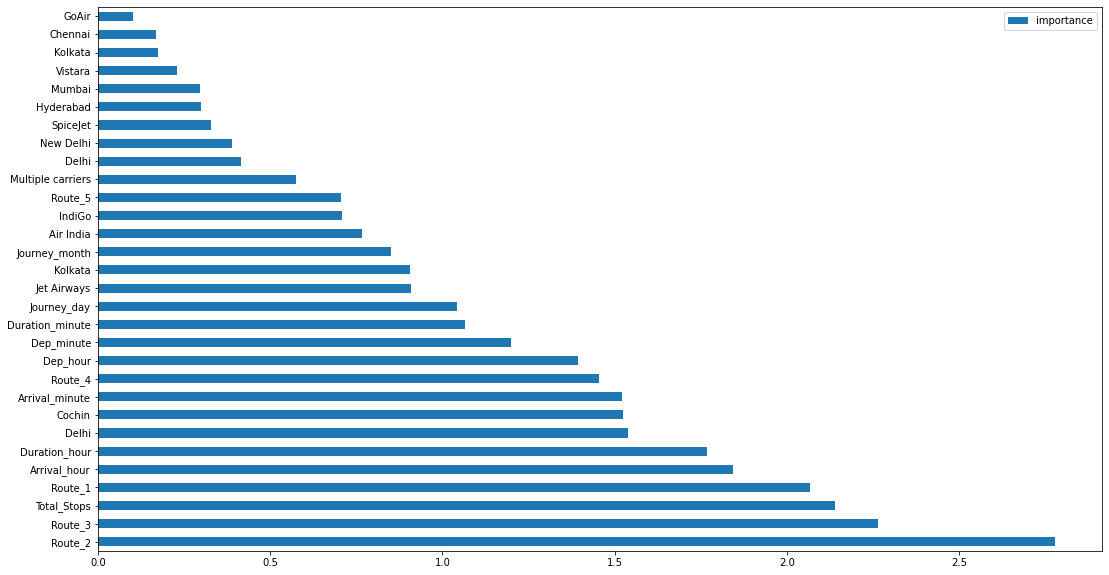

In [73]:
#plot graph of feature importances for better visualization
important_features.nlargest(30, 'importance').plot(kind='barh', figsize=(18,10))
plt.show()

### Splitting the data into Train and Test

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [ ]:
print("The size of training input is", X_train.shape)
print("The size of training output is", Y_train.shape)
print("The size of testing input is", X_test.shape)
print("The size of testing output is", Y_test.shape)

The size of training input is (8369, 34)
The size of training output is (8369,)
The size of testing input is (2093, 34)
The size of testing output is (2093,)


In [ ]:
Tr_R2 = {}
Tr_MAE = {}
Tr_RMSE = {}
Te_R2 = {}
Te_MAE = {}
Te_RMSE = {}

In [ ]:
def predict(ml_model, X, y):
    model = ml_model.fit(X_train, Y_train)
    print('Training score : {}'.format(model.score(X_train,Y_train)))
    Y_prediction = model.predict(X)
    print('predictions are: \n {}\n'.format(Y_prediction))
    r2_score = metrics.r2_score(y,Y_prediction)
    mae = metrics.mean_absolute_error(y,Y_prediction)
    mse = metrics.mean_squared_error(y,Y_prediction)
    rmse = np.sqrt(metrics.mean_squared_error(y,Y_prediction))
    print('R-Squared: {}'.format(r2_score))
    print('Mean Absolute % Error:', mae)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    sns.distplot(y-Y_prediction)
    return (r2_score, mae, rmse)

# Model Building

### Random Forest Regression

In [ ]:
# Number of trees in random forest
n_estimators=[100,200,300,400,500,600,700,800]
# Number of features to consider at every split
max_features=['auto','sqrt']
# Maximum number of levels in tree
max_depth=[1,2,3,4,5,10]
# Minimum number of samples required to split a node
min_samples_split=[2,5,10,15,100]

random_grid={
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf': [1, 2, 4]
}

reg_rf=RandomForestRegressor()

In [ ]:
rf_random=GridSearchCV(estimator=reg_rf,param_grid=random_grid,cv=3,verbose=2,n_jobs=-1)
rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 63.3min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 91.3min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 96.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
model = rf_random.best_estimator_

Train Results for Random Forest Regressor Model:-
Training score : 0.8956210554890238
predictions are: 
 [11526.76589543  4174.24615702 13245.60082144 ... 13612.26016996
 10134.0749093  17119.63629474]

R-Squared: 0.8956210554890238
Mean Absolute % Error: 1008.3482213463351
Mean Squared Error: 2028807.5236060887
Root Mean Squared Error: 1424.3621462275978


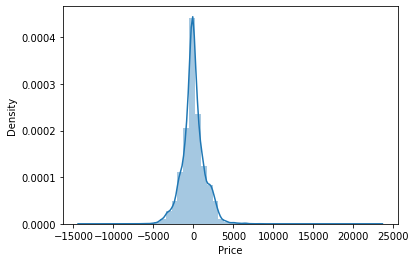

In [ ]:
# Predicting for Train results
print('Train Results for Random Forest Regressor Model:-')
Tr_R2['RF'], Tr_MAE['RF'], Tr_RMSE['RF'] = predict(model, X_train, Y_train)

Train Results for Random Forest Regressor Model:-
Training score : 0.8955237704162281
predictions are: 
 [ 2238.49575402  6913.9480549  12435.59927374 ...  8861.17394048
 17026.1196805  13049.03629984]

R-Squared: 0.8238149617094933
Mean Absolute % Error: 1188.4092023607568
Mean Squared Error: 3322339.9612154826
Root Mean Squared Error: 1822.7287130057184


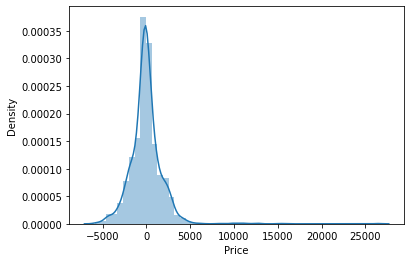

In [ ]:
# Predicting for Test results
print('Train Results for Random Forest Regressor Model:-')
Te_R2['RF'], Te_MAE['RF'], Te_RMSE['RF'] = predict(model, X_test, Y_test)

### Decision Tree Regression

In [ ]:
# Performing GridSearchCV on Decision Tree Regression
param_grid = {'max_depth': [2, 3, 5, 10, 20],
              'min_samples_leaf': [1, 2, 3, 5, 10],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['mse', 'mae', 'absolute_error']}
tree = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param_grid, cv = 10)
tree.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['mse', 'mae', 'absolute_error'],
                         'max_depth': [2, 3, 5, 10, 20],
                         

In [ ]:
model = tree.best_estimator_

Train Results for Random Forest Regressor Model:-
Training score : 0.8800952989205341
predictions are: 
 [10847.49350649  4190.91428571 13133.06818182 ... 13546.53061224
 10092.18181818 16814.03703704]

R-Squared: 0.8800952989205342
Mean Absolute % Error: 1042.858263275239
Mean Squared Error: 2330580.7584610954
Root Mean Squared Error: 1526.6239741537847


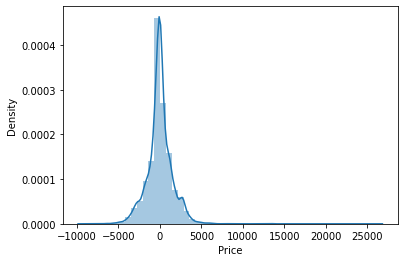

In [ ]:
# Predicting for Train results
print('Train Results for Random Forest Regressor Model:-')
Tr_R2['DT'], Tr_MAE['DT'], Tr_RMSE['DT'] = predict(model, X_train, Y_train)

Train Results for Random Forest Regressor Model:-
Training score : 0.8800515606926793
predictions are: 
 [ 2236.54545455  6555.10197368 11284.34328358 ...  5269.33333333
 16814.03703704 13158.88461538]

R-Squared: 0.8003573159771648
Mean Absolute % Error: 1244.4072746596817
Mean Squared Error: 3764683.2757712128
Root Mean Squared Error: 1940.2791746991495


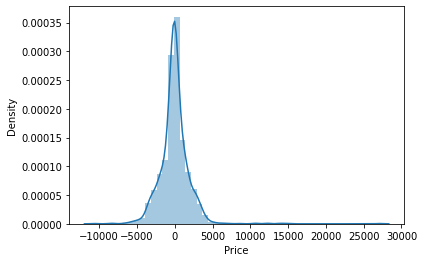

In [ ]:
# Predicting for Test results
print('Train Results for Random Forest Regressor Model:-')
Te_R2['DT'], Te_MAE['DT'], Te_RMSE['DT'] = predict(model, X_test, Y_test)

### Linear Regression

Train Results for Random Forest Regressor Model:-
Training score : 0.6164458053108804
predictions are: 
 [13704.13918002  2252.51426411 10763.01766961 ... 10834.41512595
  8183.9538604  14691.95093731]

R-Squared: 0.6164458053108804
Mean Absolute % Error: 1945.4294532673443
Mean Squared Error: 7455120.7577514015
Root Mean Squared Error: 2730.406701894683


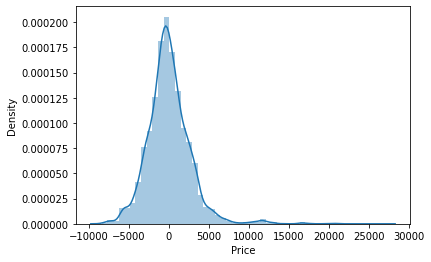

In [ ]:
# Predicting for Train results
print('Train Results for Random Forest Regressor Model:-')
Tr_R2['LR'], Tr_MAE['LR'], Tr_MSE['LR'], Tr_RMSE['LR'] = predict(LinearRegression(), X_train, Y_train)

Train Results for Random Forest Regressor Model:-
Training score : 0.6164458053108804
predictions are: 
 [ 2808.20967929  6707.12115462 11815.45233071 ...  7056.32540762
 14686.45747863 13650.28889281]

R-Squared: 0.602032192065543
Mean Absolute % Error: 1954.5029629206283
Mean Squared Error: 7504521.180725122
Root Mean Squared Error: 2739.4381140527926


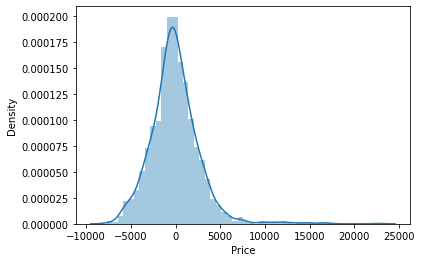

In [ ]:
# Predicting for Test results
print('Train Results for Random Forest Regressor Model:-')
Te_R2['LR'], Te_MAE['LR'], Te_RMSE['LR'] = predict(LinearRegression(), X_test, Y_test)

### KNN

Train Results for Random Forest Regressor Model:-
Training score : 0.7798057714336053
predictions are: 
 [11628.   4049.  13934.2 ... 13084.6  9608.8 13347.2]

R-Squared: 0.7798057714336053
Mean Absolute % Error: 1368.1348309236469
Mean Squared Error: 4279902.519259172
Root Mean Squared Error: 2068.792526876287


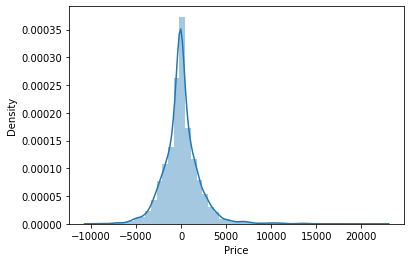

In [ ]:
# Predicting for Train results
print('Train Results for Random Forest Regressor Model:-')
Tr_R2['KNN'], Tr_MAE['KNN'], Tr_RMSE['KNN'] = predict(KNeighborsRegressor(), X_train, Y_train)

Train Results for Random Forest Regressor Model:-
Training score : 0.7798057714336053
predictions are: 
 [ 2269.   8830.2 13236.4 ...  7626.  21499.8 14186.2]

R-Squared: 0.6296957300319923
Mean Absolute % Error: 1724.990731008122
Mean Squared Error: 6982866.910043001
Root Mean Squared Error: 2642.5114777504755


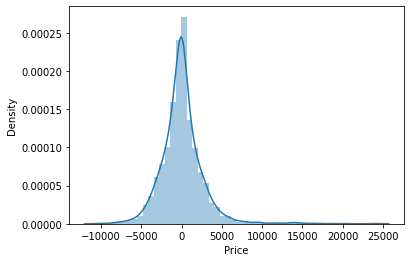

In [ ]:
# Predicting for Test results
print('Train Results for Random Forest Regressor Model:-')
Te_R2['KNN'], Te_MAE['KNN'], Te_RMSE['KNN'] = predict(KNeighborsRegressor(), X_test, Y_test)

# Comparing all the Models

In [ ]:
p = PrettyTable()
p.field_names = ["Model Name", "Tr. RMSE", "Tr. MA%E", "Tr. R-Squared", "Te. RMSE", "Te. MA%E", "Te. R-Squared",]
p.add_row(['Linear Regression',Tr_RMSE['LR'],Tr_MAE['LR'],Tr_R2['LR'],Te_RMSE['LR'],Te_MAE['LR'],Te_R2['LR']])
p.add_row([" ------------------------- "," ----------- "," ----------- "," ----------- "," ----------- "," ----------- "," ----------- "])
p.add_row(['K Nearest Neighbour',Tr_RMSE['KNN'],Tr_MAE['KNN'],Tr_R2['KNN'],Te_RMSE['KNN'],Te_MAE['KNN'],Te_R2['KNN']])
p.add_row([" ------------------------- "," ----------- "," ----------- "," ----------- "," ----------- "," ----------- "," ----------- "])
p.add_row(['Decision Tree Regressor',Tr_RMSE['DT'],Tr_MAE['DT'],Tr_R2['DT'],Te_RMSE['DT'],Te_MAE['DT'],Te_R2['DT']])
p.add_row([" ------------------------- "," ----------- "," ----------- "," ----------- "," ----------- "," ----------- "," ----------- "])
p.add_row(['Random Forest Regressor',Tr_RMSE['RF'],Tr_MAE['RF'],Tr_R2['RF'],Te_RMSE['RF'],Te_MAE['RF'],Te_R2['RF']])
print(p)

+-----------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          Model Name         |      Tr. RMSE      |      Tr. MA%E      |   Tr. R-Squared    |      Te. RMSE      |      Te. MA%E      |   Te. R-Squared    |
+-----------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Linear Regression      | 2730.406701894683  | 1945.4294532673443 | 0.6164458053108804 | 2739.4381140527926 | 1954.5029629206283 | 0.602032192065543  |
|  -------------------------  |    -----------     |    -----------     |    -----------     |    -----------     |    -----------     |    -----------     |
|     K Nearest Neighbour     | 2068.792526876287  | 1368.1348309236469 | 0.7798057714336053 | 2642.5114777504755 | 1724.990731008122  | 0.6296957300319923 |
|  -------------------------  |    -----------     |

# Conclusion:

### By comparing all the models (Linear Regression, K Nearest Neighbours, Decision Tree Regressor, Random Forest Regressor), we can conclude that Decision Tree Regressor and Random Forest Regressor performs the best.